In [1]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as v2
from torchinfo import summary 

from pathlib import Path 
import sys
sys.path.append(str(Path(__vsc_ipynb_file__).parents[1]))
import data_setup,engine

c:\Users\11kkh\Desktop\Pytorch\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = Path(__vsc_ipynb_file__).parents[2] / "data" / "food_data"
train_dir = data_dir / "train"
test_dir = data_dir / "test"
print(f"data_dir : {str(data_dir)}")
print(f"train_dir : {str(train_dir)}") , print(f"test_dir : {str(test_dir)}")

data_dir : c:\Users\11kkh\Desktop\Pytorch\data\food_data
train_dir : c:\Users\11kkh\Desktop\Pytorch\data\food_data\train
test_dir : c:\Users\11kkh\Desktop\Pytorch\data\food_data\test


(None, None)

In [3]:
IMAGE_SIZE = 224
data_transform = v2.Compose([
    v2.Resize(size=(IMAGE_SIZE,IMAGE_SIZE)),
    v2.ToImage(),
    v2.ToDtype(dtype=torch.float32 , scale = True)
])
data_transform

Compose(
      Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=warn)
      ToImage()
      ToDtype(scale=True)
)

## DataLoader 생성
- 위 논문에서는 batch_size = 4096 이지만 실제 사용할 데이터 크기와 GPU 사양으로 인해 32로 설정

In [4]:
BATCH_SIZE = 32
train_dataloader , test_dataloader, data_classes = data_setup.creat_dataloader(train_dir=train_dir ,
                                                                 test_dir= test_dir,
                                                                 transforms=data_transform,
                                                                 batch_size=BATCH_SIZE)
train_dataloader , test_dataloader , data_classes 

(<torch.utils.data.dataloader.DataLoader at 0x17ced9e2d00>,
 ['caesar_salad',
  'cheesecake',
  'chicken_curry',
  'chocolate_cake',
  'donuts',
  'french_fries',
  'hamburger',
  'miso_soup',
  'pizza',
  'ramen',
  'steak',
  'sushi',
  'tiramisu'])

## visualize image from dataLoader


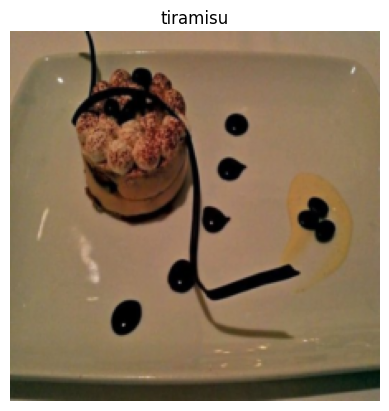

In [5]:
images , labels = next(iter(train_dataloader))
image , label = images[0] , labels[0]
visual_image=  image.permute(1,2,0)
plt.imshow(visual_image)
plt.title(f"{data_classes[label]}")
plt.axis("off")
plt.show()

## 이미지 분할
- patch_size = 16 => 하나의 이미지를 16개의 이미지로 분활
- (224,224) 이미지를 (16,16) 인 patch 이미지 196개로 분할 

(-0.5, 223.5, 15.5, -0.5)

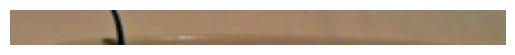

In [6]:
patch_size = 16
plt.imshow(visual_image[:patch_size, ...])
# plt.imshow(visual_image[:patch_size, :, :])
plt.axis("off")

Number of Patches per row  14.0


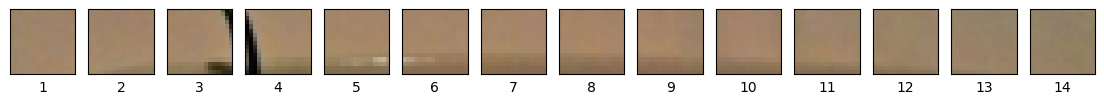

In [7]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size ==0 , "image_size 는 patch_size에 대해 나누어 떨어져야함"
print("Number of Patches per row ", num_patches)
# create a series of subplots
fig , axis = plt.subplots(nrows=1 ,
                          ncols=img_size // patch_size,
                          figsize = (num_patches,num_patches),
                          sharex=True,
                          sharey=True)
for i in range(img_size // patch_size):
    axis[i].imshow(visual_image[:patch_size, i*patch_size:i*patch_size+patch_size,:])
    axis[i].set_xlabel(i+1)
    axis[i].set_xticks([])
    axis[i].set_yticks([])

Number of Patches per row  14.0


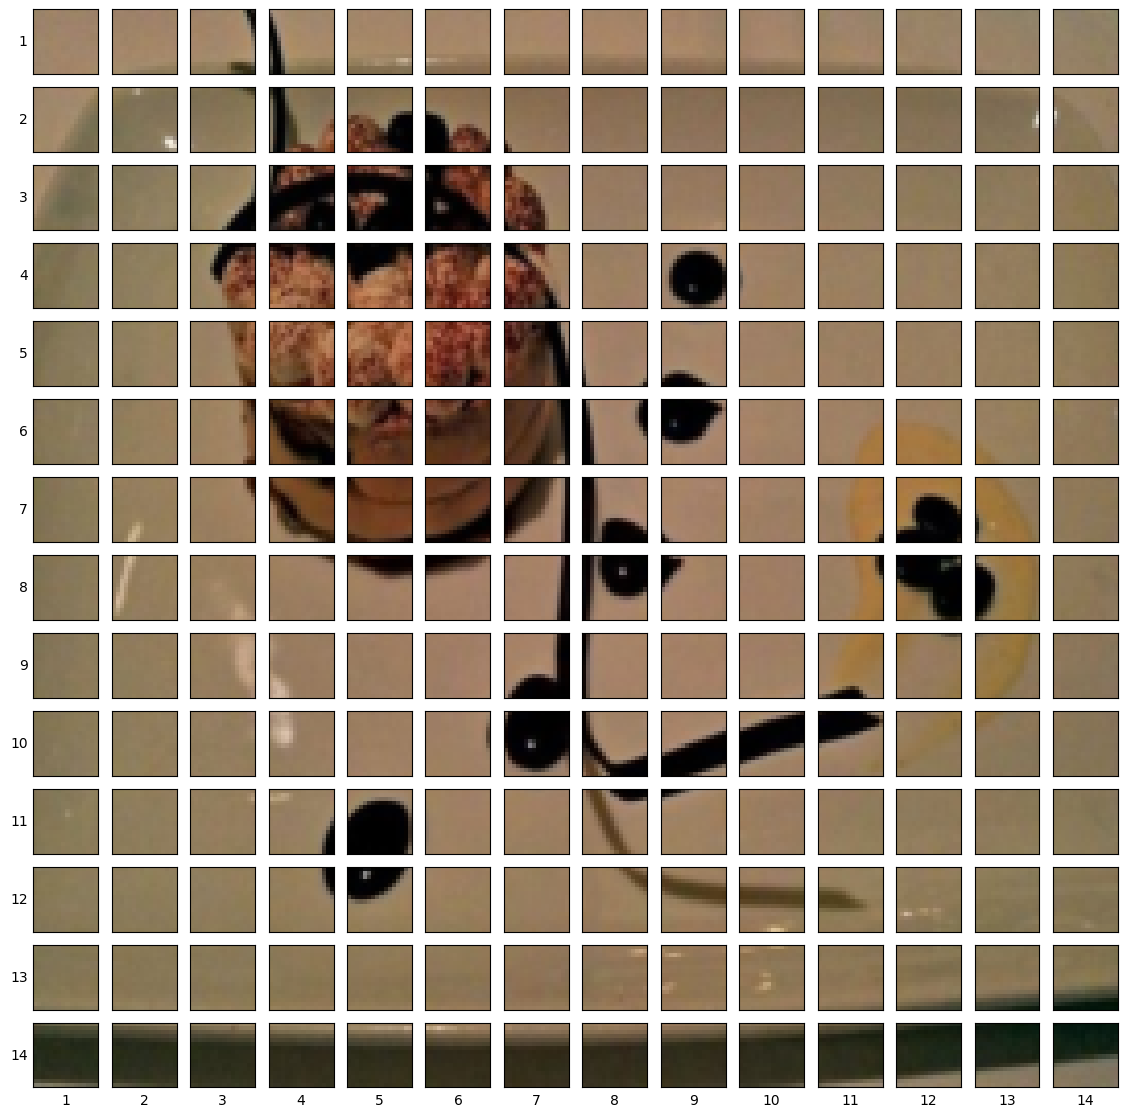

In [8]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size ==0 , "image_size 는 patch_size에 대해 나누어 떨어져야함"
print("Number of Patches per row ", num_patches)
fig , axis = plt.subplots(nrows = img_size//patch_size,
                          ncols = img_size // patch_size,
                          figsize=(num_patches , num_patches),
                          sharex=True,
                          sharey=True)
for idx , patch_h in enumerate(range(0,img_size , patch_size)):
    for idy , patch_w in enumerate(range(0,img_size , patch_size)):
        axis[idx][idy].imshow(visual_image[patch_h:patch_h+patch_size,patch_w:patch_w+patch_size ,:])
        axis[13][idy].set_xlabel(idy+1)
        axis[idx][0].set_ylabel(idx+1,rotation='horizontal',
                                  horizontalalignment="right",
                                  verticalalignment="center")
        axis[idx][idy].set_xticks([])
        axis[idx][idy].set_yticks([])
plt.show()
        

In [9]:
import torch.nn as nn
patch_size = 16

conv2d = nn.Conv2d(in_channels=3 , 
                   out_channels=patch_size**2*3,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
image_out_of_conv = conv2d(image.unsqueeze(0))
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

## visualize featuremap

random_idx : [277, 637, 318, 395, 540]


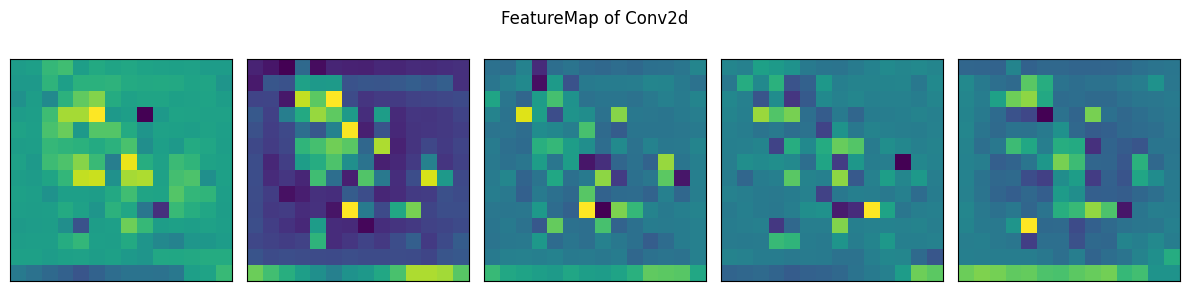

In [10]:
import random 
random_idx = random.sample(range(0,768),k=5)
fig , axis = plt.subplots(nrows=1,
                          ncols=5,
                          figsize=(12,3))
for idx , randi in enumerate(random_idx):
    featureMap = image_out_of_conv[:,randi,...].squeeze().detach().numpy()
    axis[idx].imshow(featureMap)
    axis[idx].set(xticks=[] , yticks=[])
print(f"random_idx : {random_idx}")
fig.suptitle("FeatureMap of Conv2d")
plt.tight_layout()
plt.show()


## Flattening the patch embedding
-> use `torch.nn.Flatten()`
- patch_image를 Convolution 연산으로 embedding을 했고 이를 2차원으로 변경해야함(Nx(P^2,C))

In [11]:
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [12]:
flatten = nn.Flatten(start_dim= 2,end_dim=3)
image_out_of_flattend = flatten(image_out_of_conv)
image_out_of_flattend.shape

torch.Size([1, 768, 196])

- 우리가 원하는 output = (N x (P^2C)) = (196,768)
- 현재의 output = (1,768,196)

In [13]:
image_out_of_conv_flattened_reshaped = image_out_of_flattend.permute(0,2,1)
image_out_of_conv_flattened_reshaped.shape

torch.Size([1, 196, 768])

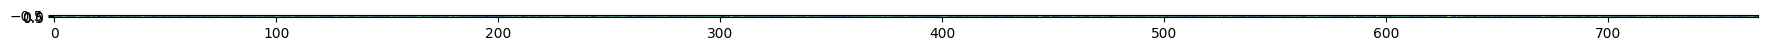

In [14]:
plt.figure(figsize=(22,22))
plt.imshow(image_out_of_conv_flattened_reshaped[:,0].detach().numpy())

## ViT patch embedding layer into Pytorch module

In [15]:
class PatchEmbedding(nn.Module):
    """_summary_

        Args:
            input_channels (_type_): _description_
            patch_size (_type_): _description_
    """
    def __init__(self , input_channels:int =3 , patch_size:int = 16, embedding_dim:int = 768):
        super().__init__()
        self._path_size = patch_size
        self.patcher = nn.Conv2d(in_channels= input_channels ,
                              out_channels= embedding_dim,
                              kernel_size=patch_size,
                              stride=patch_size,
                              padding=0)
        self.flatten = nn.Flatten(start_dim=2 , end_dim=3)
        
    def forward(self , x):
        
        assert x.shape[-1] % self._path_size == 0, f"Input image size must be divisble by patch size, image shape: {x.shape[-1]}, patch size: {self.patch_size}"
        
        output = self.patcher(x)
        output = self.flatten(output)
        output = output.permute(0,2,1)
        return output
        

In [16]:
patchify= PatchEmbedding(input_channels=3 , patch_size=16 , embedding_dim=768)
patch_embedded_image = patchify(image.unsqueeze(0))
patch_embedded_image.shape

torch.Size([1, 196, 768])

## Creating the class token for embedding
- learnable embedding 한 클래스 토큰을 추가 이때 클래스 토큰의 차원은 (D) 차원으로 앞에서의 768 차원
- `torch.cat` 연산을 통해 patch_embedding과 클래스 토큰을 합친다.(클래스 토큰은 맨 앞에 오도록)

In [17]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size , 1 , embedding_dimension,requires_grad=True))
class_token.shape


torch.Size([1, 1, 768])

In [18]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [19]:
patch_embedded_image_with_class_embedding = torch.cat((class_token,patch_embedded_image) , dim=1)
patch_embedded_image_with_class_embedding.shape , patch_embedded_image_with_class_embedding[0,:10,:]

(torch.Size([1, 197, 768]),
 tensor([[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.2037,  0.5009, -0.0316,  ...,  0.0838, -0.2255, -0.2604],
         [-0.2001,  0.4949,  0.0031,  ...,  0.0642, -0.2222, -0.2492],
         ...,
         [-0.2042,  0.4840,  0.0432,  ...,  0.0805, -0.1920, -0.2487],
         [-0.2004,  0.4772,  0.0461,  ...,  0.0706, -0.1938, -0.2440],
         [-0.1966,  0.4978,  0.0326,  ...,  0.0722, -0.1978, -0.2352]],
        grad_fn=<SliceBackward0>))

## Creating the position embedding

In [20]:
number_of_patchs = 196
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]
position_embedding = nn.Parameter(torch.ones(1,number_of_patchs+1,embedding_dimension,requires_grad=True))
position_embedding.shape


torch.Size([1, 197, 768])

In [21]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding+position_embedding
patch_and_position_embedding.shape

torch.Size([1, 197, 768])

## 지금 까지 과정 통합



In [22]:
patch_size= 16
height , width = image.shape[1] , image.shape[2]
x = image.unsqueeze(0)
print(x.shape)
patch_embedded_layer = PatchEmbedding(3 , patch_size=patch_size , embedding_dim=768)
patch_embedding = patch_embedded_layer(x)
print("patch_embedding : ",patch_embedding.shape)
# create class token
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = torch.nn.Parameter(torch.randn(batch_size , 1, embedding_dimension),requires_grad=True)
print("class token",class_token.shape)
# cat class token and patch_embedding
patch_embedding_class_token = torch.cat((class_token,patch_embedding), dim=1)
print("patch_embedding_class_token" , patch_embedding_class_token.shape)
# create position embedding
number_of_patchs = int(height*width/patch_size**2)
print("number_of_patchs" , number_of_patchs)
position_embedding = torch.randn(batch_size , number_of_patchs+1 , embedding_dimension)
print("position_embedding",position_embedding.shape)
# add position embedding and patch_embedding_class_token
patch_and_position_embedding = patch_embedding_class_token+position_embedding
print("patch_and_position_embedding",patch_and_position_embedding.shape)

torch.Size([1, 3, 224, 224])
patch_embedding :  torch.Size([1, 196, 768])
class token torch.Size([1, 1, 768])
patch_embedding_class_token torch.Size([1, 197, 768])
number_of_patchs 196
position_embedding torch.Size([1, 197, 768])
patch_and_position_embedding torch.Size([1, 197, 768])


## Equation2 : Multi-Head Attention(MSA)

In [23]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self , 
                 embedding_dim:int=768 ,
                 num_heads:int=12,
                 drop_out_rate:float = 0):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads = num_heads,
                                                    dropout=drop_out_rate,
                                                    batch_first=True)
    
    def forward(self, x):
        output = self.layer_norm(x)
        attn_output , _ = self.multihead_attn(query = x,
                                     key = x,
                                     value = x,
                                     need_weights = False)
        return attn_output
        
        

In [24]:
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768 , num_heads=12 , drop_out_rate=0)
patched_image_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"input : {patch_and_position_embedding.shape}")
print(f"output : {patched_image_msa_block.shape}")


input : torch.Size([1, 197, 768])
output : torch.Size([1, 197, 768])


## Equation3 : Multilayer Perceptron(MLP)

In [25]:
class MLPBlock(nn.Module):
    def __init__(self, 
                 embedding_dim:int=768,
                 mlp_size:int = 3072,
                 drop_out_rate:float = 0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim , 
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=drop_out_rate),
            nn.Linear(in_features=mlp_size , 
                      out_features=embedding_dim),
            nn.Dropout(p=drop_out_rate)
        )
    def forward(self , x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x
        

In [26]:
mlp_block = MLPBlock(embedding_dim=768,mlp_size=3072,drop_out_rate=0.1)
patched_image_through_mlp_bloc = mlp_block(patched_image_msa_block)
print("input MLP block : " , patched_image_msa_block.shape)
print("output MLP block : ", patched_image_through_mlp_bloc.shape)

input MLP block :  torch.Size([1, 197, 768])
output MLP block :  torch.Size([1, 197, 768])


## Create the Transformer Encoder
- combine MSA block and MLP block and residual layer
- 

In [27]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self , 
                 embedding_dim = 768,
                 num_heads = 12,
                 mlp_size:int = 3072,
                 drop_out_rate_MSA:float = 0,
                 drop_out_rate_MLP:float = 0.1,
                 ):
        super().__init__()
        
        # create MSA block
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     drop_out_rate=drop_out_rate_MSA
                                                     )
        # create MLP block
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                  mlp_size = mlp_size,
                                  drop_out_rate=drop_out_rate_MLP)
    def forward(self , x):
        x = self.msa_block(x) +x
        x = self.mlp_block(x) +x
        return x   

In [28]:
from torchinfo import summary
transformer_encoder_block = TransformerEncoderBlock(embedding_dim=768 ,
                                                    num_heads = 12,
                                                    mlp_size=3072,
                                                    drop_out_rate_MSA=0,
                                                    drop_out_rate_MLP=0.1)

summary(model = transformer_encoder_block , input_size = (1,196+1,768),)

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoderBlock                  [1, 197, 768]             --
├─MultiheadSelfAttentionBlock: 1-1       [1, 197, 768]             --
│    └─LayerNorm: 2-1                    [1, 197, 768]             1,536
│    └─MultiheadAttention: 2-2           [1, 197, 768]             2,362,368
├─MLPBlock: 1-2                          [1, 197, 768]             --
│    └─LayerNorm: 2-3                    [1, 197, 768]             1,536
│    └─Sequential: 2-4                   [1, 197, 768]             --
│    │    └─Linear: 3-1                  [1, 197, 3072]            2,362,368
│    │    └─GELU: 3-2                    [1, 197, 3072]            --
│    │    └─Dropout: 3-3                 [1, 197, 3072]            --
│    │    └─Linear: 3-4                  [1, 197, 768]             2,360,064
│    │    └─Dropout: 3-5                 [1, 197, 768]             --
Total params: 7,087,872
Trainable params: 7,087,872
Non-tr

## Creating ViT model
- PatchEmbedding 구현 
- 여러개로 쌓은 TransfromerEncdoerBlock
- 최종 classifier

In [29]:
class Vit(nn.Module):
    def __init__(self , 
                 img_size:int =224,
                 in_channels:int = 3,
                 patch_size:int =16,
                 num_transformer_layers:int =12,
                 embedding_dim:int = 768,
                 mlp_size:int = 3072,
                 num_heads:int = 12,
                 attn_drop_out_rate:float = .0,
                 mlp_drop_out_rate: float = 0.1,
                 embedding_dropout:float = 0.1,
                 num_classes:int = 1000
                 ):
        super().__init__()
        
        assert img_size % patch_size ==0, f"Error img_size : {img_size} / patch_size : {patch_size} / divided = {img_size % patch_size}"
        
        # 4step
        self.num_patchs = (img_size**2) // (patch_size**2)
        # 5step
        self.class_embedding = nn.Parameter(torch.randn(1,1 , embedding_dim) , requires_grad=True)
        # 6step
        self.position_embedding = nn.Parameter(torch.randn(1,self.num_patchs+1 , embedding_dim), requires_grad = True)
        # 7step 
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        # 8step
        self.patch_embedding = PatchEmbedding(input_channels=in_channels,
                                                patch_size=patch_size,
                                                embedding_dim=embedding_dim)
        # 9step
        self.transformer_encoder = nn.Sequential(
            *[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                    num_heads = num_heads ,
                                    mlp_size=mlp_size,
                                    drop_out_rate_MSA=attn_drop_out_rate,
                                    drop_out_rate_MLP=mlp_drop_out_rate
                                    ) for _ in range(num_transformer_layers)]
        )
        
        # 10step create clssifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim , out_features=num_classes)
        )
        
    def forward(self , x):
        batch_size = x.shape[0]
        class_token = self.class_embedding.expand(batch_size , -1,-1) # (batch_size x 1 x embedding_dim)
        x = self.patch_embedding(x) # (batch_size x N x embedding_dim)
        x = torch.cat((class_token,x),dim=1) # (batch_size x N+1 x embedding_dim)
        x = x+self.position_embedding 
        x = self.embedding_dropout(x)
        x = self.transformer_encoder(x) # (batch_size x N+1 x embedding_dim)
        # x = x[:,0,:] # (batch_size x embedding_dim)
        x = self.classifier(x[:,0,:]) # (batch_size x num_classes)
        return x 
    

In [30]:
nn.Parameter(torch.randn(1,1 , 30) , requires_grad=True).expand(10,-1,-1).shape

torch.Size([10, 1, 30])

In [31]:
vit = Vit(num_classes=13)
batch_size = 32
summary(vit , input_size = (batch_size , 3,224,224))

Layer (type:depth-idx)                             Output Shape              Param #
Vit                                                [32, 13]                  152,064
├─PatchEmbedding: 1-1                              [32, 196, 768]            --
│    └─Conv2d: 2-1                                 [32, 768, 14, 14]         590,592
│    └─Flatten: 2-2                                [32, 768, 196]            --
├─Dropout: 1-2                                     [32, 197, 768]            --
├─Sequential: 1-3                                  [32, 197, 768]            --
│    └─TransformerEncoderBlock: 2-3                [32, 197, 768]            --
│    │    └─MultiheadSelfAttentionBlock: 3-1       [32, 197, 768]            2,363,904
│    │    └─MLPBlock: 3-2                          [32, 197, 768]            4,723,968
│    └─TransformerEncoderBlock: 2-4                [32, 197, 768]            --
│    │    └─MultiheadSelfAttentionBlock: 3-3       [32, 197, 768]            2,363,904
│   

## Optimizer, Loss 생성

In [ ]:
from torch.optim import Adam
optimizer = Adam(vit.parameters() , lr=0.003,betas=(0.9,0.999),weight_decay=0.3)

loss_fn = torch.nn.CrossEntropyLoss()

# seed setting
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set device
device = "cuda" if torch.cuda.is_available() else "cpu"
results = engine.train(
    model=vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs = 3,
    device = device
)

In [33]:
import torchvision.transforms as transforms
transforms.Compose(
    [transforms.crop_size(224,224)]
                   )

AttributeError: module 'torchvision.transforms' has no attribute 'crop_size'